In [5]:
import pandas as pd
import numpy as np
import torch
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from itertools import combinations
import re
import string
# import pymorphy2 # не работает на новых версиях python
from natasha import Doc, Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM

from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from sklearn.metrics import f1_score
import gensim.downloader as api

2025-05-18 18:37:28.110566: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747593448.355381      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747593448.436516      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
#pip install natasha
#pip install iterative-stratification

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [8]:
train_path = f"/kaggle/input/dl-2025-study-competition-2/train.csv"
test_path = f"/kaggle/input/dl-2025-study-competition-2/test.csv"

# БЛОК 1: Анализ данных

In [9]:
df = pd.read_csv(train_path)

In [10]:
df.head()


,id,text,labels
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0


In [11]:
print(df.shape)

(29568, 3)


### Подготовка данных: преобразуем строку в список

In [12]:
df['labels'] = df['labels'].apply(lambda x: [int(i) for i in x.split()])
df.head()

,id,text,labels
0,0,15 января\nДетская развлекательная программа\n...,"[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ..."
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, ..."
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ..."
3,3,Впервые в Уфе танцевальная терапия в группе с ...,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...","[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, ..."


### Анализ баланса классов

In [13]:
all_labels = [label for labels in df['labels'] for label in labels] #Собираем все метки в один большой список

label_counts = Counter(all_labels)

label_freq = {f'label_{i}': 0 for i in range(20)}
for i in range(20):
    label_freq[f'label_{i}'] = sum(df['labels'].apply(lambda x: x[i]))

for label, count in label_freq.items():
    print(f'{label}: {count} раз ({count / len(df) * 100:.2f}%)') #выводим частоты меток и их процентное соотношение

label_0: 15582 раз (52.70%)
label_1: 18979 раз (64.19%)
label_2: 1490 раз (5.04%)
label_3: 1776 раз (6.01%)
label_4: 17812 раз (60.24%)
label_5: 99 раз (0.33%)
label_6: 206 раз (0.70%)
label_7: 22555 раз (76.28%)
label_8: 23344 раз (78.95%)
label_9: 20497 раз (69.32%)
label_10: 12811 раз (43.33%)
label_11: 18510 раз (62.60%)
label_12: 23071 раз (78.03%)
label_13: 22997 раз (77.78%)
label_14: 22296 раз (75.41%)
label_15: 14925 раз (50.48%)
label_16: 21933 раз (74.18%)
label_17: 23523 раз (79.56%)
label_18: 24300 раз (82.18%)
label_19: 5765 раз (19.50%)


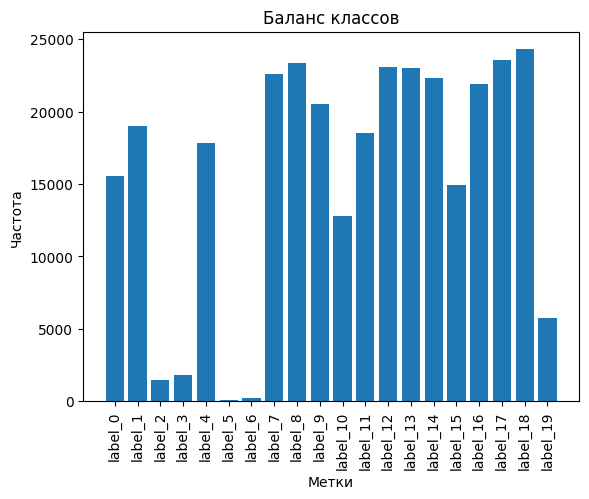

In [14]:
labels, counts = zip(*label_freq.items())
plt.bar(labels, counts)
plt.xticks(rotation=90)
plt.xlabel('Метки')
plt.ylabel('Частота')
plt.title('Баланс классов')
plt.show()

**Дисбаланс классов**: 5 и 6 метки *практически не встречаются*, 2, 3 и 19 *редко*,
7,8,12,13,14,17,18 *часто* (>75%)

### Анализ представителей классов

In [15]:
for i in [5,6]:
    print(f'\nПримеры для label_{i}:')
    examples = df[df['labels'].apply(lambda x: x[i] == 1)]['text'].sample(2)
    for example in examples:
        display(example)


Примеры для label_5:


'ЛИТЕРАТУРНЫЙ ФЕСТИВАЛЬ «12 ЭТАЖЕЙ»\nс 1 по 7 декабря 2023 года\nг. Минеральные Воды | Центральная городская библиотека им. Котовской\nС 1 по 7 декабря в Центральной городской библиотеке пройдет фестиваль «12 этажей» в рамках федерального проекта «Гений места», который обещает быть интересным для гостей всех возрастов.\n📌\n1 декабря известный писатель Олег Губенко – редактор «Терского сборника», автор книг о русском казачестве – познакомит присутствующих с деятельностью Казачьего культурно-исторического центра, рассказав о его истории и значимости.\n📌\n5 декабря участники фестиваля смогут воплотить свои творческие идеи, создавая собственные книжки-малышки. Это станет прекрасной возможностью для каждого человека самостоятельно наполнить книгу своими любимыми текстами и оригинальными иллюстрациями. В этот же день будет предоставлена возможность послушать онлайн-лекцию, рассказывающую о том, какие жанры женщины предпочитали использовать, а также о богатстве сюжетов и уникальности их выраж

'ЦИРКОВАЯ ПРОГРАММА «ЗАГАДКА СТАРОЙ ИГРУШКИ»(0+)\nс 16 сентября по 15 октября 2023 года\nг. Кисловодск | Кисловодский государственный цирк | Билеты от 1000 р.\n«Росгосцирк» и «Кисловодский государственный цирк» дарит всем рецепт отличного осеннего настроения и приглашает отправиться в таинственное путешествие под названием "Загадка старой игрушки".\nНеобыкновенный подарок приведёт нашу героиню и вас в удивительный мир, где артисты российского цирка станут проводниками для зрителей, желающих узнать тайны разных уголков планеты. Все жанры циркового искусства не во сне, а наяву промелькнут калейдоскопом и надолго запомнятся своими впечатлениями.\nВы увидите парящих в небе акробатов, обладателей высших международных цирковых наград, под руководством заслуженного артиста России Владимира Вавилова; эквилибристов на катушках Вячеслава Быхона и Кристину Нусс; гимнастов на полотнах, ремнях, кольцах и с хула-хупами. Все они проведут вас по самым сложным и запутанным страницам истории смелой дево


Примеры для label_6:


'6 и 7 апреля\nБесплатные лекции и мастер-классы от Института психологии САРГИ\nАрт-квадрат\nЧернышевского 88\n6 апреля с 14:00 до 15:30\n🔵\nКузнецова Алина Филаритовна, магистр клинической психологии, член Ассоциации КПТ, преподаватель, старший куратор и супервизор института: лекция и ответы на вопросы «Чувства родителей. Как с ними быть?»\n7 апреля с 14:00 до 16:00\n🔵\nАникина Дина Дамировна проведет практический мастер-класс для детей «Просто об эмоциях».\nЗапись на мастер-класс по телефону: 89196197748\n🔵\nГареева Аида Фанисовна. Мастер-класс по нейрографике для взрослых: «достижение целей».\nЗапись на мастер-класс по телефону: 89196197748\n🔵\nРината Нигматуллина\nАрт- практикум - «Мои чувства, мое настроение»\nЗапись на мастер-класс по телефону: 89196197748\n@afishaufa02'

'14.12 в 16:30 БИЗНЕС-РАЗБОРЫ «Новый уровень» + НЕТВОРКИНГ на 70+ чел.\nДля тех, кто хочет:\n➖\nПопасть на радио, TV и большую сцену\n➖\nПостроить крепкую семью, сделать мужа богаче, получать дорогие подарки\n➖\nВыйти на топ-уровень клиентов и вырасти х10 в финансах в 2025 году\nНа бизнес-разборах и нетворкинге «Новый уровень» встречаемся красиво и результативно!\nЧто вы получаете:\n▶️\nПрокачаете свои медиа-навыки и поймёте как вам «засветиться» на радио и TV\n▶️\nЗаложите фундамент для создания крепкой семьи и обогащения в духовном и материальном\n▶️\nИнструменты и возможности для х10 более крупных сцен, охватов, людей и проектов в 2025 году\nХедлайнер Наталья Терешкина:\n•\nРадио- и телеэксперт, музыкальный автор-исполнитель, спикер Останкино\n•\nЗапустила 50+ проектов, 9 песен\n•\n10.000+ международных клиентов, среди которых члены ЮНЕСКО, правительство РФ, телеведущие\n🗓️\n14\nдекабря в 16:30\n📍\nм.Чистые пруды,\nул. Мясницкая, вл. 24/7, с2\nВход свободный, обязательная\nРЕГИСТРАЦ

In [16]:
for i in [2,3,19]:
    print(f'\nПримеры для label_{i}:')
    examples = df[df['labels'].apply(lambda x: x[i] == 1)]['text'].sample(2)
    for example in examples:
        print(f'\n{example}')


Примеры для label_2:

Петербургский театр танца "Шоу под дождем"
4 ноября - Бугульма
7 ноября - Набережные Челны
Спектакль вобрал в себя всё: энергию и драйв, юмор и позитив, романтику и любовь! Но самое незабываемое — это финал спектакля — танцы, которые исполняются под потоками воды!
Они покорили 300 городов, 14 стран, 3 континента и миллионы восторженных зрителей по всему миру — для этих парней нет ничего невозможного! Их выступление — это стопроцентный Sold Out в любом зале.
«Искушение» — уникальный танцевальный проект, аналогов которому нет ни в одной стране мира, российский феномен и гордость Санкт-Петербурга.
👉
Билетов всё меньше, успейте купить без комиссии — на
ВсеКонцерты.рф
.

⭕️
Мюзикл-шоу "НОТР ДАМ де ПАРИ" & "РОМЕО И ДЖУЛЬЕТТА"
20 июля в 19.00
📍
ДК им.Зуева (м.Белорусская, ул.Лесная, 8)
🔥
скидка 50%
❗️
по промокоду: НОТР50
🔥
❗️
до 15.00 - 20 июля 2022
❗️
https://iframeab-pre6372.intickets.ru/seance/12521205/
💐
Светлана Светикова,
💐
Эд Шульжевский,
💐
Александр Постоленко,

In [17]:
for i in [7,12,14]:
    print(f'\nПримеры для label_{i}:')
    examples = df[df['labels'].apply(lambda x: x[i] == 1)]['text'].sample(2)
    for example in examples:
        print(f'\n{example}')


Примеры для label_7:

Сезон летних цен
в Цирке Чудес
Цирковое шоу
Алиса в стране чудес
🏛
Дом Молодежи Санкт-Петербурга
📍
м. Московская, Новоизмайловский пр, 48
🎫
Билеты по ссылке здесь
🏛
ДМ "Атлант"
📍
м. Академическая, ул. Руставели, 37
🎫
Билеты по ссылке здесь
🏛
КЦ "Максим"
📍
м. Черная речка, Ланское ш., 35
🎫
Билеты по ссылке здесь
💚
Скидка по промокоду SPB9490
💚
До 4х лет вход бесплатный (сидят на коленках у родителей)
🥰
Билеты со скидками
@teatrspb

Вы еще не были на Концертах у Моря в Севкабель Порту?
🌊
Тогда не упустите последние дни лета! В эти выходные здесь будет звучать музыка Фрэнка Синатры и легендарные рок хиты в исполнении оркестра!
🌊
18 августа — джазовый концерт хитов
«Frank Sinatra»
у моря
Человек-легенда Фрэнк Синатра записал около 100 известных синглов от «Moon River» и «Strangers In The Night» до «My Way». Исполним эти песни вместе с обладателем глубокого бархатного голоса Даниилом Можеговым и джазовым трио Дмитрия Тихонова.
🌊
19 августа — концерт
«Рок с симфоническ

### Анализ текстов

In [18]:
df['text_length'] = df['text'].apply(len)
print(f'Средняя длина текста: {df["text_length"].mean():.2f}\n')

min_length = df['text_length'].min()
min_text = df[df['text_length'] == min_length]['text'].iloc[0]
print(f'Минимальная длина текста: {min_length}')
print(f'Текст с минимальной длиной:\n{min_text}\n')

max_length = df['text_length'].max()
max_text = df[df['text_length'] == max_length]['text'].iloc[0]
print(f'Максимальная длина текста: {max_length}')
print(f'Текст с максимальной длиной:\n{max_text}')

Средняя длина текста: 604.81

Минимальная длина текста: 1
Текст с минимальной длиной:
😂

Максимальная длина текста: 4081
Текст с максимальной длиной:
🎉
🎊
Отмечаем день города в Москве: интересные мероприятия и идеи для прогулок  (7-8 сентября)
🎶
Интересные мероприятия выходных:
Праздничный концерт в честь Дня города в Зарядье
https://t.me/mostrips/30196
Бесплатное посещение музея Булгакова
https://t.me/mscculture/24036
Фестиваль "Театральный марш"
https://t.me/mosafishka/18902
День города в галерее Ильи Глазунова
https://t.me/mostrips/30226
Бесплатное посещение Государственного музея А.С. Пушкина.
https://t.me/moscowafishi/8565
Выступление всадников Кремлевской школы верховой езды
https://t.me/moscowafishniy/13500
День города в парке Сказка
https://t.me/afishamoskvy/5969
Встреча с фигуристкой Евгенией Медведевой в Манеже
https://t.me/moscowtopafisha/13033
Пушкинский бал в саду Баумана
https://t.me/mscculture/24029
Бесплатный концерт на фабрике "Красный октябрь"
https://t.me/mosafishka/

In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
stop_words = list(stopwords.words('russian'))

In [21]:
vectorizer = CountVectorizer(stop_words= stop_words)  # частотный анализ слов
X = vectorizer.fit_transform(df['text'])
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0]))
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
print(sorted_word_freq[:10])

[('00', 33363), ('билеты', 20006), ('19', 14324), ('https', 12909), ('20', 11456), ('30', 11093), ('промокоду', 9774), ('спектакль', 8233), ('это', 8060), ('ссылке', 8000)]


### Анализ корреляций между метками

In [22]:
label_pairs = []
for labels in df['labels']:
    active_labels = [i for i, val in enumerate(labels) if val == 1]
    label_pairs.extend(combinations(active_labels, 2))

pair_counts = Counter(label_pairs)
for pair, count in pair_counts.most_common(5):
    print(f'Пара label_{pair[0]} - label_{pair[1]}: {count} раз')

Пара label_17 - label_18: 21961 раз
Пара label_7 - label_18: 20778 раз
Пара label_12 - label_18: 20634 раз
Пара label_9 - label_18: 20303 раз
Пара label_8 - label_18: 20245 раз


**Вывод**: высокая корреляция между метками, возможно, описывает общие черты текстов

Нужно будет использовать модель, устойчивую к дисбалансу

# Блок 2: Очистка текста для разных моделей

In [23]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

stop_words = set(stopwords.words('russian'))

### Общая функция для очистки для TF-IDF, Word2Vec, CNN и RNN

In [24]:
def clean_text_general(text, remove_stopwords=False):
    text = text.lower() # Приведение к нижнему регистру
    text = re.sub(f"[{string.punctuation}]", "", text) # Удаление пунктуации
    text = re.sub(r'\s+', ' ', text).strip() # Удаление лишних пробелов
    
    if remove_stopwords: # Удаление стоп-слов (если требуется)
        text = " ".join(word for word in text.split() if word not in stop_words)
    
    return text

### Очистка для TF-IDF, используя лемматизацию

In [25]:
def clean_text_tfidf(text):
    text = clean_text_general(text, remove_stopwords=True)  # Общая очистка с удалением стоп-слов
    
    doc = Doc(text)  # Лемматизация с Natasha
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    
    lemmatized_text = ' '.join(token.lemma for token in doc.tokens if token.lemma)    
    return text

### Очистка для BERT

In [26]:
def clean_text_bert(text):
    return text # пока без очистки

### Применение пайплайнов для очистки

In [27]:
df_copy = df.copy()

df_copy['tfidf_text'] = df_copy['text'].apply(clean_text_tfidf)  # Для TF-IDF
df_copy['word2vec_text'] = df_copy['text'].apply(lambda x: clean_text_general(x, remove_stopwords=False))  # Для Word2Vec
df_copy['cnn_rnn_text'] = df_copy['text'].apply(lambda x: clean_text_general(x, remove_stopwords=False))  # Для CNN/RNN
df_copy['bert_text'] = df_copy['text'].apply(clean_text_bert)  # Для BERT

In [28]:
print("Исходный текст:\n", df_copy['text'].head(1))
print("\nОчищенный текст для TF-IDF:\n", df_copy['tfidf_text'].head(1))
print("\nОчищенный текст для Word2Vec:\n", df_copy['word2vec_text'].head(1))
print("\nОчищенный текст для CNN/RNN:\n", df_copy['cnn_rnn_text'].head(1))
print("\nОчищенный текст для BERT:\n", df_copy['bert_text'].head(1))

Исходный текст:
 0    15 января\nДетская развлекательная программа\n...
Name: text, dtype: object

Очищенный текст для TF-IDF:
 0    15 января детская развлекательная программа 15...
Name: tfidf_text, dtype: object

Очищенный текст для Word2Vec:
 0    15 января детская развлекательная программа 15...
Name: word2vec_text, dtype: object

Очищенный текст для CNN/RNN:
 0    15 января детская развлекательная программа 15...
Name: cnn_rnn_text, dtype: object

Очищенный текст для BERT:
 0    15 января\nДетская развлекательная программа\n...
Name: bert_text, dtype: object


# БЛОК 3: Построение моделей

In [29]:
X = df['text'].values
y = np.array(df['labels'].tolist())

In [30]:
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) #1 разбиение
train_idx, val_idx = next(msss.split(X, y)) #отбираем индексы разбиения на обучающую и валидационные выборки
train_df = df.iloc[train_idx].copy() #обучающий df по индексам разбиения
val_df = df.iloc[val_idx].copy() #валидационный df по индексам разбиения

y_train = np.array(train_df['labels'].tolist()) #метки обучающей
y_val = np.array(val_df['labels'].tolist()) #метки валидации

### Функция warmup шедулера

In [31]:
#optimizer - оптимизатор для работы шедулера
#warmup_steps - кол-во шагов, в течение которых скорость обучения линейно увеличивается с 0 до max
#total_steps - общее кол-во шагов, включая warmup_steps

def warmup_scheduler(optimizer, warmup_steps, total_steps):
    def lr_lambda(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        return max(0.0, float(total_steps - step) / float(max(1, total_steps - warmup_steps)))
    return LambdaLR(optimizer, lr_lambda)


#Можно добавить тестирование для проверки каждой функции

# scheduler = warmup_scheduler(optimizer, warmup_steps=100, total_steps=1000)
# for step in range(1000):
#     print(f"Step {step}: LR multiplier = {scheduler.get_last_lr()[0] / optimizer.defaults['lr']}")
#     scheduler.step()


### Функция обучения моделей

In [62]:
def train_model(model, train_loader, val_loader, epochs, lr, warmup_steps, total_steps, patience, model_name):
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr) #Оптимизатор AdamW - чем отличается от остальных
    scheduler = warmup_scheduler(optimizer, warmup_steps, total_steps) #запускает функцию шедулера, прописанную выше
    criterion = nn.BCEWithLogitsLoss() #функция потерь, объединяющая сигмоиду и бинарную кросс-энтропию (подходит для многометочной классификации)
    
    best_val_f1 = 0 #плавающее значение лучшего f1-score на валидации
    patience_counter = 0 #счетчик эпох для ранней остановки
    train_losses, val_losses, train_f1s, val_f1s = [], [], [], [] #списки для хранения лосей и значений f1
    
    for epoch in range(epochs):
        
        #перевод модели в режим обучения (включение dropout, batch normalization etc.)
        model.train() 
        train_loss, train_preds, train_labels = 0, [], []
        for inputs, labels in train_loader: #итерируется по батчам обучающей выборки
            inputs, labels = inputs.to(device), labels.to(device) #переносит входы и метки на устройство device
            optimizer.zero_grad() #обнуление градиента оптимизатора перед вычислением новых градиентов
            outputs = model(inputs) #пропускаем входы через модель, получая предсказания
            loss = criterion(outputs, labels) #вычисляем функцию потерь между предсказаниями и метками
            loss.backward() #обратное распространение ошибки для вычисления градиента
            optimizer.step() #обновление параметров модели, используя градиенты ???
            train_loss += loss.item() #добавляем значение лося текущего батча к общей сумме лосей
            train_preds.extend(torch.sigmoid(outputs).detach().cpu().numpy()) #применяем сигмоиду к выходам модели, detach() - отключение градиентов, cpu() - переносим на цпу, преобразовываем в np массив
            train_labels.extend(labels.detach().cpu().numpy())
        
        scheduler.step() #обновляет скорость обучения согласно планировщику
        train_loss /= len(train_loader) #средняя потеря по всем батчам
        train_f1 = f1_score(np.array(train_labels) > 0.5, np.array(train_preds) > 0.5, average='macro') #вычисляем f1-score для train, используя макроусреднение
        train_losses.append(train_loss) #лосс текущей эпохи
        train_f1s.append(train_f1) #f1-score текущей эпохи

        #перевод модели в режим оценки (отключение dropout, batch_normalization)
        model.eval()
        val_loss, val_preds, val_labels = 0, [], []
        with torch.no_grad(): #отключение вычисления градиентов 
            for inputs, labels in val_loader: #итерируется ПО БАТЧАМ валидационной выборки (для оценки)
                #все дальше аналогично обучающему циклу, но без обратного распределения и обновления параметров
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
                val_labels.extend(labels.detach().cpu().numpy())
        
        val_loss /= len(val_loader) #средняя потеря на валидации 
        val_f1 = f1_score(np.array(val_labels) > 0.5, np.array(val_preds) > 0.5, average='macro') #f1-score на валидации
        val_losses.append(val_loss) #сохранение лосей валидации
        val_f1s.append(val_f1) #сохранение f1 для валидации
        
        print(f'{model_name} Эпоха {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')
        
        #если текущий f1-score на валидации лучше предыдущего
        if val_f1 > best_val_f1: 
            best_val_f1 = val_f1 #обновление лучшего рез-та
            patience_counter = 0 #счетчик терпения сбрасывается
            torch.save(model.state_dict(), f'best_{model_name}.pth') #сохраняется состояние модели
        else:
            patience_counter += 1 #увеличивается счетчик терпения
            if patience_counter >= patience: #прерывание обучения, если терпение истекло 
                print('Ранняя остановка')
                break



    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title(f'{model_name} Лосс')
    plt.subplot(1, 2, 2)
    plt.plot(train_f1s, label='Train F1')
    plt.plot(val_f1s, label='Val F1')
    plt.legend()
    plt.title(f'{model_name} F1-Скор')
    plt.savefig(f'{model_name}_графики.png')
    plt.show()
    plt.close()

    return best_val_f1

### TF-IDF + нейронная сеть

tfidf_nn Эпоха 1/100: Train Loss: 0.6961, Train F1: 0.3173, Val Loss: 0.6961, Val F1: 0.3168
tfidf_nn Эпоха 2/100: Train Loss: 0.6936, Train F1: 0.3731, Val Loss: 0.6903, Val F1: 0.4315
tfidf_nn Эпоха 3/100: Train Loss: 0.6753, Train F1: 0.5680, Val Loss: 0.6549, Val F1: 0.6065
tfidf_nn Эпоха 4/100: Train Loss: 0.6141, Train F1: 0.6043, Val Loss: 0.5723, Val F1: 0.5851
tfidf_nn Эпоха 5/100: Train Loss: 0.5290, Train F1: 0.5882, Val Loss: 0.4959, Val F1: 0.5930
tfidf_nn Эпоха 6/100: Train Loss: 0.4717, Train F1: 0.6042, Val Loss: 0.4530, Val F1: 0.6122
tfidf_nn Эпоха 7/100: Train Loss: 0.4358, Train F1: 0.6185, Val Loss: 0.4214, Val F1: 0.6233
tfidf_nn Эпоха 8/100: Train Loss: 0.4064, Train F1: 0.6331, Val Loss: 0.3945, Val F1: 0.6388
tfidf_nn Эпоха 9/100: Train Loss: 0.3810, Train F1: 0.6494, Val Loss: 0.3719, Val F1: 0.6571
tfidf_nn Эпоха 10/100: Train Loss: 0.3593, Train F1: 0.6681, Val Loss: 0.3528, Val F1: 0.6738
tfidf_nn Эпоха 11/100: Train Loss: 0.3404, Train F1: 0.6829, Val Loss

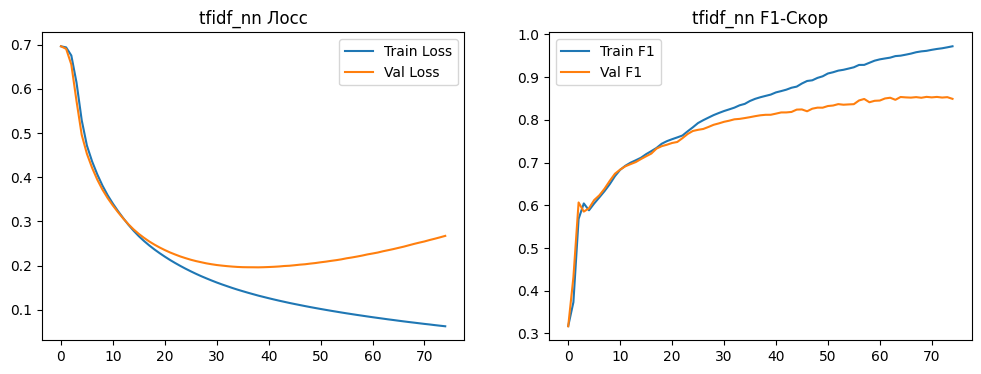

In [63]:
train_df['tfidf_text'] = train_df['text'].apply(clean_text_tfidf) #применение очистки текста
val_df['tfidf_text'] = val_df['text'].apply(clean_text_tfidf)
tfidf_vectorizer = TfidfVectorizer(max_features=5000) #создание векторизатора, который преобразовыет текст в матрицу TF-IDF, max_features = 5000 (ограничение словаря на 5000 слов)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['tfidf_text']).toarray() #выполнение векторизации на train
X_val_tfidf = tfidf_vectorizer.transform(val_df['tfidf_text']).toarray() #выполнение векторизации на val

class TFIDF_NN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim): #input_dim - 5000 признаков (размер входного слоя)
        #hidden_dim - скрытый слой, output_dim - размер выходного слоя (число меток) = 20
        super(TFIDF_NN, self).__init__() #инициализация
        self.fc1 = nn.Linear(input_dim, hidden_dim) #первый полносвязный слой
        self.relu = nn.ReLU() #активация RELU
        self.fc2 = nn.Linear(hidden_dim, output_dim) #второй полносвязный слой
    def forward(self, x): #определяет метод прямого прохода
        x = self.fc1(x) #первый полносвязный слой к входному тензору Х
        x = self.relu(x) #RELU к выходу первого слоя
        x = self.fc2(x) #второй полносвязный слой
        return x

model_tfidf = TFIDF_NN(input_dim=5000, hidden_dim=128, output_dim=20) #создание модели
train_dataset_tfidf = TensorDataset(torch.tensor(X_train_tfidf, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)) #TensorDataset для обучающих данных
val_dataset_tfidf = TensorDataset(torch.tensor(X_val_tfidf, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)) #TensorDataset для валидационных данных
train_loader_tfidf = DataLoader(train_dataset_tfidf, batch_size=64, shuffle=True) #DataLoader для обучающих данных
val_loader_tfidf = DataLoader(val_dataset_tfidf, batch_size=64) #DataLoader для валидационных данных
original_f1 = train_model(model_tfidf, train_loader_tfidf, val_loader_tfidf, epochs=100, lr=1e-3, warmup_steps=100, total_steps=1000, patience=5, model_name='tfidf_nn') #Обучение модели с параметрами

#!!! Надо чтобы total_steps = len(train_loader_tfidf) * epochs

In [34]:
# Очистка текста и векторизация
test_df = pd.read_csv(test_path)
test_df['tfidf_text'] = test_df['text'].apply(clean_text_tfidf)
X_test_tfidf = tfidf_vectorizer.transform(test_df['tfidf_text']).toarray()  # Используем transform, а не fit_transform!

# Преобразование в тензор
X_test_tensor = torch.tensor(X_test_tfidf, dtype=torch.float32)

In [35]:
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model_tfidf.eval()
all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)  # Переносим входные данные на GPU
        outputs = model_tfidf(inputs)
        batch_preds = (torch.sigmoid(outputs)>0.5).int().cpu().numpy()  # Переносим предсказания обратно на CPU для numpy
        all_predictions.extend(batch_preds)

all_predictions = np.array(all_predictions)
predictions = [' '.join(map(str, row)) for row in all_predictions]

ids = list(range(29568, 36960))

submission = pd.DataFrame({
    'id': ids,
    'labels': predictions
})

# Сохраняем в CSV-файл
submission.to_csv('/kaggle/working/submission.csv', index=False)


In [36]:
submission.head()

,id,labels
0,29568,0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0
1,29569,0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1
2,29570,0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0
3,29571,1 1 0 0 1 0 0 1 1 1 0 0 1 0 1 0 1 0 1 0
4,29572,0 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 1 0


In [37]:
submission_shabl = pd.read_csv('/kaggle/input/dl-2025-study-competition-2/sample_submission.csv')

In [38]:
submission_shabl.head()

,id,labels
0,29568,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1,29569,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
2,29570,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
3,29571,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
4,29572,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


### W2V + нейронная сеть

[==================================================] 100.0% 198.8/198.8MB downloaded
w2v_nn Эпоха 1/20: Train Loss: 0.6902, Train F1: 0.3304, Val Loss: 0.6903, Val F1: 0.3297
w2v_nn Эпоха 2/20: Train Loss: 0.6890, Train F1: 0.3444, Val Loss: 0.6878, Val F1: 0.3632
w2v_nn Эпоха 3/20: Train Loss: 0.6849, Train F1: 0.4512, Val Loss: 0.6818, Val F1: 0.4903
w2v_nn Эпоха 4/20: Train Loss: 0.6756, Train F1: 0.5376, Val Loss: 0.6685, Val F1: 0.5736
w2v_nn Эпоха 5/20: Train Loss: 0.6564, Train F1: 0.5718, Val Loss: 0.6433, Val F1: 0.5736
w2v_nn Эпоха 6/20: Train Loss: 0.6249, Train F1: 0.5743, Val Loss: 0.6069, Val F1: 0.5736
w2v_nn Эпоха 7/20: Train Loss: 0.5862, Train F1: 0.5743, Val Loss: 0.5681, Val F1: 0.5736
w2v_nn Эпоха 8/20: Train Loss: 0.5513, Train F1: 0.5743, Val Loss: 0.5381, Val F1: 0.5736
w2v_nn Эпоха 9/20: Train Loss: 0.5274, Train F1: 0.5743, Val Loss: 0.5199, Val F1: 0.5736
Ранняя остановка


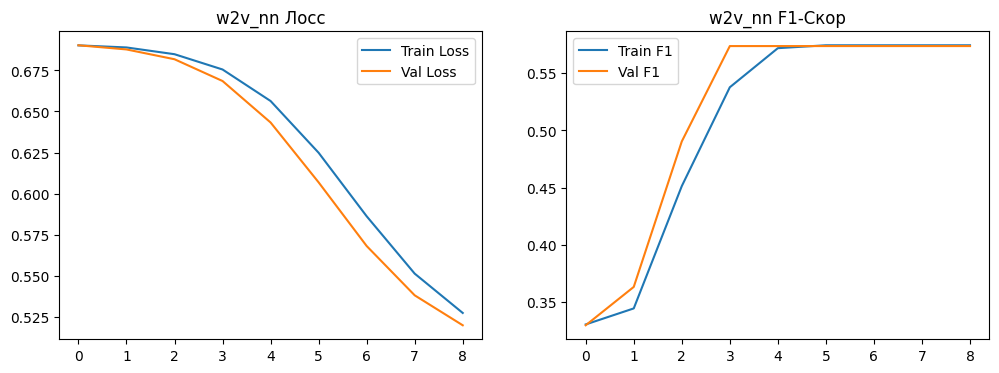

In [39]:
train_df['w2v_text'] = train_df['text'].apply(clean_text_general)
val_df['w2v_text'] = val_df['text'].apply(clean_text_general)

# Загрузка предобученной модели Word2Vec
word2vec_model = api.load('word2vec-ruscorpora-300')
def get_avg_word2vec(text, model):
    words = text.split()
    vectors = [model[word] for word in words if word in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

X_train_w2v = np.vstack(train_df['w2v_text'].apply(lambda x: get_avg_word2vec(x, word2vec_model)))
X_val_w2v = np.vstack(val_df['w2v_text'].apply(lambda x: get_avg_word2vec(x, word2vec_model)))

class W2V_NN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(W2V_NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model_w2v = W2V_NN(input_dim=word2vec_model.vector_size, hidden_dim=128, output_dim=20)
train_dataset_w2v = TensorDataset(torch.tensor(X_train_w2v, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset_w2v = TensorDataset(torch.tensor(X_val_w2v, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
train_loader_w2v = DataLoader(train_dataset_w2v, batch_size=64, shuffle=True)
val_loader_w2v = DataLoader(val_dataset_w2v, batch_size=64)
train_model(model_w2v, train_loader_w2v, val_loader_w2v, epochs=20, lr=1e-3, warmup_steps=100, total_steps=1000, patience=5, model_name='w2v_nn')



### CNN со встроенным эмбеддингом

cnn Эпоха 1/100: Train Loss: 0.6998, Train F1: 0.4015, Val Loss: 0.6992, Val F1: 0.4018
cnn Эпоха 2/100: Train Loss: 0.3865, Train F1: 0.6683, Val Loss: 0.3317, Val F1: 0.6852
cnn Эпоха 3/100: Train Loss: 0.3233, Train F1: 0.6878, Val Loss: 0.3170, Val F1: 0.6905
cnn Эпоха 4/100: Train Loss: 0.3119, Train F1: 0.6927, Val Loss: 0.3081, Val F1: 0.6945
cnn Эпоха 5/100: Train Loss: 0.3013, Train F1: 0.6975, Val Loss: 0.2999, Val F1: 0.7083
cnn Эпоха 6/100: Train Loss: 0.2884, Train F1: 0.7168, Val Loss: 0.2847, Val F1: 0.7047
cnn Эпоха 7/100: Train Loss: 0.2726, Train F1: 0.7274, Val Loss: 0.2709, Val F1: 0.7147
cnn Эпоха 8/100: Train Loss: 0.2562, Train F1: 0.7534, Val Loss: 0.2590, Val F1: 0.7238
cnn Эпоха 9/100: Train Loss: 0.2419, Train F1: 0.7692, Val Loss: 0.2497, Val F1: 0.7688
cnn Эпоха 10/100: Train Loss: 0.2294, Train F1: 0.7900, Val Loss: 0.2414, Val F1: 0.7623
cnn Эпоха 11/100: Train Loss: 0.2177, Train F1: 0.8080, Val Loss: 0.2366, Val F1: 0.7616
cnn Эпоха 12/100: Train Loss: 

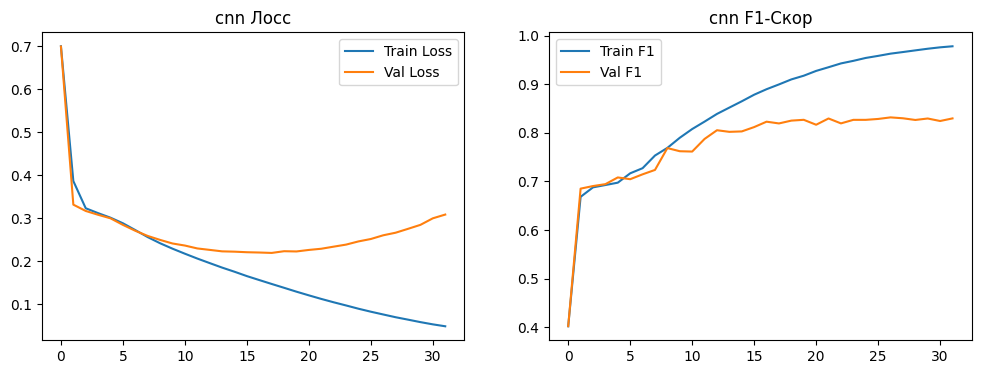

In [40]:
train_df['cnn_text'] = train_df['text'].apply(clean_text_general)
val_df['cnn_text'] = val_df['text'].apply(clean_text_general)
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_df['cnn_text'])
X_train_seq = tokenizer.texts_to_sequences(train_df['cnn_text'])
X_val_seq = tokenizer.texts_to_sequences(val_df['cnn_text'])
X_train_pad = pad_sequences(X_train_seq, maxlen=200)
X_val_pad = pad_sequences(X_val_seq, maxlen=200)

class CNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, max_len):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv1 = nn.Conv1d(embed_dim, 128, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(12672, num_classes)
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

model_cnn = CNN(vocab_size=10000, embed_dim=128, num_classes=20, max_len=200)
train_dataset_cnn = TensorDataset(torch.tensor(X_train_pad, dtype=torch.long), torch.tensor(y_train, dtype=torch.float32))
val_dataset_cnn = TensorDataset(torch.tensor(X_val_pad, dtype=torch.long), torch.tensor(y_val, dtype=torch.float32))
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=64, shuffle=True)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=64)
train_model(model_cnn, train_loader_cnn, val_loader_cnn, epochs=100, lr=1e-3, warmup_steps=100, total_steps=1000, patience=5, model_name='cnn')



In [41]:
# Предполагается, что test_df содержит колонки 'id' и 'text'
test_df['cnn_text'] = test_df['text'].apply(clean_text_general)
X_test_seq = tokenizer.texts_to_sequences(test_df['cnn_text'])
X_test_pad = pad_sequences(X_test_seq, maxlen=200)

test_dataset = TensorDataset(torch.tensor(X_test_pad, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model_cnn.eval()
model_cnn.to(device)
predictions = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)
        outputs = model_cnn(inputs)
        # Применяем сигмоиду, чтобы получить вероятности
        probs = torch.sigmoid(outputs)
        # Применяем порог 0.5 для бинарных предсказаний
        preds = (probs > 0.5).float().cpu().numpy()
        predictions.append(preds)

predictions = np.vstack(predictions)

# Создаем DataFrame
submission_df_cnn = pd.DataFrame({
    'id': test_df['id'],
    'labels': [' '.join(map(str, pred.astype(int))) for pred in predictions]
})

# Сохраняем в CSV
submission_df_cnn.to_csv('/kaggle/working/submission_cnn.csv', index=False)

In [42]:
submission_df_cnn.head()

,id,labels
0,29568,1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
1,29569,0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1
2,29570,0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0
3,29571,1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 0 1 0
4,29572,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 1 0 1


### RNN со встроенным эмбеддингом

rnn Эпоха 1/100: Train Loss: 0.6945, Train F1: 0.3884, Val Loss: 0.6944, Val F1: 0.3863
rnn Эпоха 2/100: Train Loss: 0.6860, Train F1: 0.4470, Val Loss: 0.6763, Val F1: 0.5023
rnn Эпоха 3/100: Train Loss: 0.6318, Train F1: 0.5615, Val Loss: 0.4854, Val F1: 0.5648
rnn Эпоха 4/100: Train Loss: 0.4369, Train F1: 0.6237, Val Loss: 0.4024, Val F1: 0.6434
rnn Эпоха 5/100: Train Loss: 0.3598, Train F1: 0.6790, Val Loss: 0.3380, Val F1: 0.6898
rnn Эпоха 6/100: Train Loss: 0.3286, Train F1: 0.6927, Val Loss: 0.3219, Val F1: 0.6934
rnn Эпоха 7/100: Train Loss: 0.3155, Train F1: 0.6970, Val Loss: 0.3111, Val F1: 0.6973
rnn Эпоха 8/100: Train Loss: 0.3061, Train F1: 0.7003, Val Loss: 0.3027, Val F1: 0.6998
rnn Эпоха 9/100: Train Loss: 0.2963, Train F1: 0.7034, Val Loss: 0.2936, Val F1: 0.7034
rnn Эпоха 10/100: Train Loss: 0.2848, Train F1: 0.7072, Val Loss: 0.2800, Val F1: 0.7078
rnn Эпоха 11/100: Train Loss: 0.2731, Train F1: 0.7137, Val Loss: 0.2696, Val F1: 0.7177
rnn Эпоха 12/100: Train Loss: 

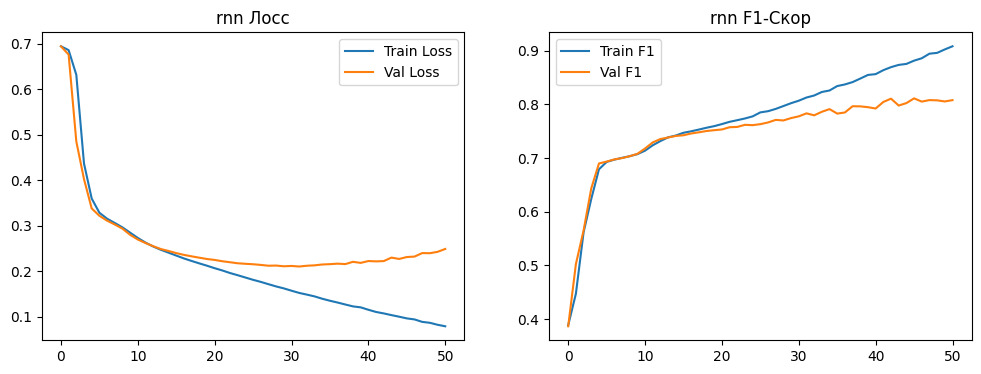

In [43]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        x = self.fc(h_n[-1])
        return x

model_rnn = RNN(vocab_size=10000, embed_dim=128, hidden_dim=128, output_dim=20)
train_dataset_rnn = TensorDataset(torch.tensor(X_train_pad, dtype=torch.long), torch.tensor(y_train, dtype=torch.float32))
val_dataset_rnn = TensorDataset(torch.tensor(X_val_pad, dtype=torch.long), torch.tensor(y_val, dtype=torch.float32))
train_loader_rnn = DataLoader(train_dataset_rnn, batch_size=64, shuffle=True)
val_loader_rnn = DataLoader(val_dataset_rnn, batch_size=64)
train_model(model_rnn, train_loader_rnn, val_loader_rnn, epochs=100, lr=1e-3, warmup_steps=100, total_steps=1000, patience=5, model_name='rnn')



In [44]:
model_rnn.eval()
model_rnn.to(device)

predictions = []
with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)
        outputs = model_rnn(inputs)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float().cpu().numpy()
        predictions.append(preds)

predictions = np.vstack(predictions)

submission_df_rnn = pd.DataFrame({
    'id': test_df['id'],
    'labels': [' '.join(map(str, pred.astype(int))) for pred in predictions]
})
submission_df_rnn.to_csv('/kaggle/working/submission_rnn.csv', index=False)

In [45]:
submission_df_rnn.head()

,id,labels
0,29568,0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0
1,29569,0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1
2,29570,0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0
3,29571,1 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 1 0
4,29572,0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 1


### RuBERT 

In [ ]:
train_df['bert_text'] = train_df['text'].apply(clean_text_bert)
val_df['bert_text'] = val_df['text'].apply(clean_text_bert)
bert_tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

class BertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float32)
        }

class BertMultilabel(nn.Module):
    def __init__(self, bert_model, num_labels):
        super(BertMultilabel, self).__init__()
        self.bert = bert_model
        self.classifier = nn.Linear(bert_model.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        logits = self.classifier(pooled_output)
        return logits

def train_bert_model(model, train_loader, val_loader, epochs, lr, warmup_steps, total_steps, patience):
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = warmup_scheduler(optimizer, warmup_steps, total_steps)
    criterion = nn.BCEWithLogitsLoss()
    
    best_val_f1 = 0
    patience_counter = 0
    train_losses, val_losses, train_f1s, val_f1s = [], [], [], []
    
    for epoch in range(epochs):
        model.train()
        train_loss, train_preds, train_labels = 0, [], []
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
            train_labels.extend(labels.detach().cpu().numpy())
        
        scheduler.step()
        train_loss /= len(train_loader)
        train_f1 = f1_score(np.array(train_labels) > 0.5, np.array(train_preds) > 0.5, average='macro')
        train_losses.append(train_loss)
        train_f1s.append(train_f1)
        
        model.eval()
        val_loss, val_preds, val_labels = 0, [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
                val_labels.extend(labels.detach().cpu().numpy())
        
        val_loss /= len(val_loader)
        val_f1 = f1_score(np.array(val_labels) > 0.5, np.array(val_preds) > 0.5, average='macro')
        val_losses.append(val_loss)
        val_f1s.append(val_f1)
        
        print(f'RuBERT Эпоха {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), 'best_rubert.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Ранняя остановка')
                break
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title('RuBERT Лосс')
    plt.subplot(1, 2, 2)
    plt.plot(train_f1s, label='Train F1')
    plt.plot(val_f1s, label='Val F1')
    plt.legend()
    plt.title('RuBERT F1-Скор')
    plt.savefig('rubert_графики.png')
    plt.show()
    plt.close()

train_dataset_bert = BertDataset(train_df['bert_text'].values, y_train, bert_tokenizer, max_len=128)
val_dataset_bert = BertDataset(val_df['bert_text'].values, y_val, bert_tokenizer, max_len=128)
train_loader_bert = DataLoader(train_dataset_bert, batch_size=16, shuffle=True)
val_loader_bert = DataLoader(val_dataset_bert, batch_size=16)
bert_model = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased')
model_bert = BertMultilabel(bert_model, num_labels=20)
train_bert_model(model_bert, train_loader_bert, val_loader_bert, epochs=5, lr=2e-5, warmup_steps=50, total_steps=500, patience=2)



# Блок 4. Генератор

In [47]:
gpt_model_name = "ai-forever/rugpt3large_based_on_gpt2"
gpt_tokenizer = AutoTokenizer.from_pretrained(gpt_model_name)
gpt_model = AutoModelForCausalLM.from_pretrained(gpt_model_name).to(device)
gpt_model.eval()

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/622 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.14G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.14G [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1536)
    (wpe): Embedding(2048, 1536)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=4608, nx=1536)
          (c_proj): Conv1D(nf=1536, nx=1536)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=6144, nx=1536)
          (c_proj): Conv1D(nf=1536, nx=6144)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1536, out_features=50257, bias=False)
)

In [52]:
def generate_text_for_labels_batch(label_sets, batch_size=8):
    generated_texts = []
    for i in range(0, len(label_sets), batch_size):
        batch_labels = label_sets[i:i + batch_size]
        prompts = []
        for labels in batch_labels:
            label_str = ", ".join([f"метка_{i}" for i, l in enumerate(labels) if l == 1])
            if not label_str:
                label_str = "нейтральное событие"
            prompts.append(f"Создай афишу мероприятия на русском языке, связанную с {label_str}. Укажи дату, время, место и краткое описание.")
        
        # Токенизация батча промптов
        inputs = gpt_tokenizer(prompts, return_tensors="pt", max_length=50, truncation=True, padding=True).to(device)
        
        try:
            # Батчевая генерация
            outputs = gpt_model.generate(
                **inputs,
                max_length=100,  # Уменьшено для ускорения
                num_return_sequences=1,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                pad_token_id=gpt_tokenizer.eos_token_id
            )
            
            # Декодирование результатов
            for output in outputs:
                text = gpt_tokenizer.decode(output, skip_special_tokens=True)
                generated_texts.append(text)
        except Exception as e:
            print(f"Ошибка при генерации текста: {str(e)}")
            generated_texts.extend(["Ошибка генерации"] * len(batch_labels))
    
    return generated_texts


In [53]:
def generate_examples(num_examples, label_distribution):
    generated_texts = []
    generated_labels = []
    label_sets = []
    
    # Сэмплируем метки
    for _ in range(num_examples):
        labels = [1 if np.random.rand() < label_distribution[i] else 0 for i in range(20)]
        label_sets.append(labels)
        generated_labels.append(labels)
    
    # Генерируем тексты батчами с прогресс-баром
    print("Генерация текстов...")
    generated_texts = generate_text_for_labels_batch(label_sets, batch_size=8)
    
    return pd.DataFrame({'text': generated_texts, 'labels': generated_labels})

### 1. Расчет распределения меток и генерация примеров

In [54]:
label_distribution = np.mean(np.array(train_df['labels'].tolist()), axis=0)
try:
    generated_df = generate_examples(1000, label_distribution)
except KeyboardInterrupt:
    print("Генерация прервана пользователем. Сохранение промежуточных результатов...")
    generated_df = pd.DataFrame({'text': [], 'labels': []})  # Пустой DataFrame при прерывании


Генерация текстов...


### 2. Обогащение датасета

In [57]:
augmented_train_df = pd.concat([train_df, generated_df], ignore_index=True)

### 3. Подготовка обогащенных данных

In [58]:
augmented_train_df['tfidf_text'] = augmented_train_df['text'].apply(clean_text_tfidf)
X_train_augmented = tfidf_vectorizer.transform(augmented_train_df['tfidf_text']).toarray()
y_train_augmented = np.array(augmented_train_df['labels'].tolist())

train_dataset_augmented = TensorDataset(torch.tensor(X_train_augmented, dtype=torch.float32), torch.tensor(y_train_augmented, dtype=torch.float32))
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=64, shuffle=True)

### 4. Обучение модели на обогащенных данных

tfidf_nn_augmented Эпоха 1/100: Train Loss: 0.6899, Train F1: 0.3334, Val Loss: 0.6899, Val F1: 0.3332
tfidf_nn_augmented Эпоха 2/100: Train Loss: 0.6873, Train F1: 0.3518, Val Loss: 0.6834, Val F1: 0.3879
tfidf_nn_augmented Эпоха 3/100: Train Loss: 0.6670, Train F1: 0.4971, Val Loss: 0.6443, Val F1: 0.5316
tfidf_nn_augmented Эпоха 4/100: Train Loss: 0.6025, Train F1: 0.5693, Val Loss: 0.5585, Val F1: 0.5808
tfidf_nn_augmented Эпоха 5/100: Train Loss: 0.5214, Train F1: 0.5799, Val Loss: 0.4907, Val F1: 0.5809
tfidf_nn_augmented Эпоха 6/100: Train Loss: 0.4738, Train F1: 0.5881, Val Loss: 0.4555, Val F1: 0.5985
tfidf_nn_augmented Эпоха 7/100: Train Loss: 0.4432, Train F1: 0.6091, Val Loss: 0.4265, Val F1: 0.6180
tfidf_nn_augmented Эпоха 8/100: Train Loss: 0.4152, Train F1: 0.6263, Val Loss: 0.3992, Val F1: 0.6345
tfidf_nn_augmented Эпоха 9/100: Train Loss: 0.3904, Train F1: 0.6433, Val Loss: 0.3758, Val F1: 0.6533
tfidf_nn_augmented Эпоха 10/100: Train Loss: 0.3685, Train F1: 0.6620, Va

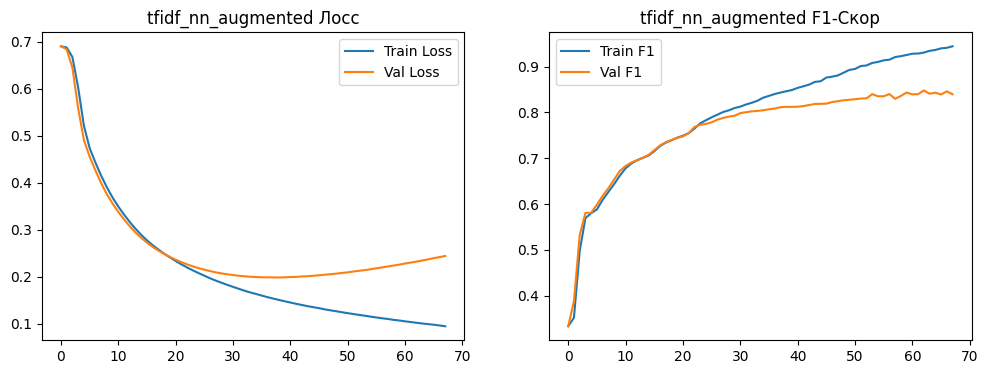

In [65]:
model_tfidf_augmented = TFIDF_NN(input_dim=5000, hidden_dim=128, output_dim=20)
augmented_f1 = train_model(model_tfidf_augmented, train_loader_augmented, val_loader_tfidf, epochs=100, lr=1e-3, warmup_steps=100, total_steps=1000, patience=5, model_name='tfidf_nn_augmented')

### 5. Сравнение и выводы

In [66]:
print(f"\nИсходный F1-score: {original_f1:.4f}")
print(f"Обогащенный F1-score: {augmented_f1:.4f}")
if augmented_f1 > original_f1:
    print("Качество улучшилось! Сгенерированные данные, вероятно, добавили разнообразия, улучшив обобщение модели, особенно для редких меток.")
else:
    print("Качество не улучшилось или ухудшилось. Возможные причины: сгенерированные тексты недостаточно соответствуют исходным данным, содержат шум или модель уже достигла предела на исходных данных.")


Исходный F1-score: 0.8536
Обогащенный F1-score: 0.8479
Качество не улучшилось или ухудшилось. Возможные причины: сгенерированные тексты недостаточно соответствуют исходным данным, содержат шум или модель уже достигла предела на исходных данных.
